![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 8 - CNN Architectures</center>
### <center> ResNet </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/MainResNet.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/08_CnnArchitectures/DeepLearningFramework ./DeepLearningFramework

In [6]:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR-10 dataset:

In [7]:
oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [8]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

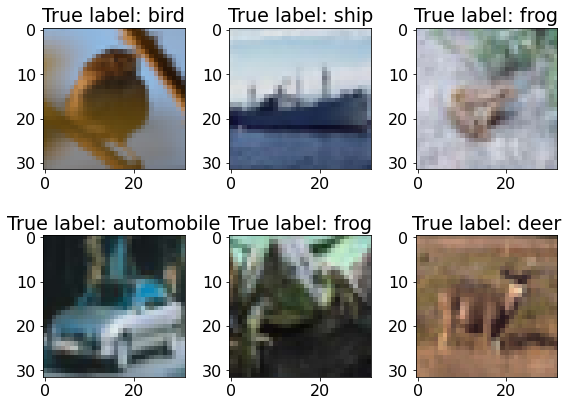

In [13]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(8, 6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [14]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [15]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [17]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

#### Define the model (ResNet):
<img src='https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/ResBlock.png?raw=true' alt="Drawing" style="width: 150px;"/>

In [19]:
def LeftBranch(C):
    oLeft = nn.Sequential(
        nn.Conv2d(C, C, 3, padding=1, bias=False), nn.BatchNorm2d(C), nn.ReLU(),
        nn.Conv2d(C, C, 3, padding=1, bias=False), nn.BatchNorm2d(C),
    )
    return oLeft
               
def RightBranch(C):
    oRight = nn.Identity() #-- Identity

    return oRight

In [20]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super(ResBlock, self).__init__()
        
        self.oLeft  = LeftBranch(C)
        self.oRight = RightBranch(C)

    def forward(self, mX):
        mZ = nn.functional.relu(self.oLeft(mX) + self.oRight(mX))
        return mZ
        
torchsummary.summary(ResBlock(64), (64, 56, 56));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 56, 56]          --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          36,864
|    └─BatchNorm2d: 2-2                  [-1, 64, 56, 56]          128
|    └─ReLU: 2-3                         [-1, 64, 56, 56]          --
|    └─Conv2d: 2-4                       [-1, 64, 56, 56]          36,864
|    └─BatchNorm2d: 2-5                  [-1, 64, 56, 56]          128
├─Identity: 1-2                          [-1, 64, 56, 56]          --
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 231.28
Input size (MB): 0.77
Forward/backward pass size (MB): 6.12
Params size (MB): 0.28
Estimated Total Size (MB): 7.17


In [21]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 90
    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        ResBlock(d),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(d, 10)
    )
    
    oModel.apply(weights_init)
    
    return oModel


torchsummary.summary(GetModel(), (3, 32, 32));

Layer (type:depth-idx)                   Output Shape              Param #
├─Identity: 1-1                          [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 90, 32, 32]          2,430
├─BatchNorm2d: 1-3                       [-1, 90, 32, 32]          180
├─ReLU: 1-4                              [-1, 90, 32, 32]          --
├─Conv2d: 1-5                            [-1, 90, 32, 32]          72,900
├─BatchNorm2d: 1-6                       [-1, 90, 32, 32]          180
├─ReLU: 1-7                              [-1, 90, 32, 32]          --
├─MaxPool2d: 1-8                         [-1, 90, 16, 16]          --
├─ResBlock: 1-9                          [-1, 90, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 90, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 90, 16, 16]          72,900
|    |    └─BatchNorm2d: 3-2             [-1, 90, 16, 16]          180
|    |    └─ReLU: 3-3                    [-1, 90, 16, 16]          --
|

In [22]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()

In [26]:
nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)

oModel        = GetModel().to(DEVICE)
oOptim        = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-2)
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=3e-2, total_steps=nIter)

lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 1.25721 | Val loss: 1.23687 | Train Accuracy: 0.5438 | Val Accuracy: 0.5440 | epoch time: 49.229 | <-- Checkpoint!
Epoch 001: | Train loss: 0.91013 | Val loss: 1.49968 | Train Accuracy: 0.6788 | Val Accuracy: 0.5337 | epoch time: 49.507 |
Epoch 002: | Train loss: 0.76361 | Val loss: 0.93590 | Train Accuracy: 0.7350 | Val Accuracy: 0.6796 | epoch time: 49.893 | <-- Checkpoint!
Epoch 003: | Train loss: 0.69220 | Val loss: 1.52529 | Train Accuracy: 0.7601 | Val Accuracy: 0.5712 | epoch time: 49.028 |
Epoch 004: | Train loss: 0.63903 | Val loss: 0.93837 | Train Accuracy: 0.7815 | Val Accuracy: 0.6830 | epoch time: 49.022 | <-- Checkpoint!
Epoch 005: | Train loss: 0.59090 | Val loss: 0.77604 | Train Accuracy: 0.8006 | Val Accuracy: 0.7357 | epoch time: 49.039 | <-- Checkpoint!
Epoch 006: | Train loss: 0.55883 | Val loss: 0.84857 | Train Accuracy: 0.8088 | Val Accuracy: 0.7307 | epoch time: 48.870 |
Epoch 007: | Train loss: 0.52946 | Val loss: 1.12631 | Train Accurac

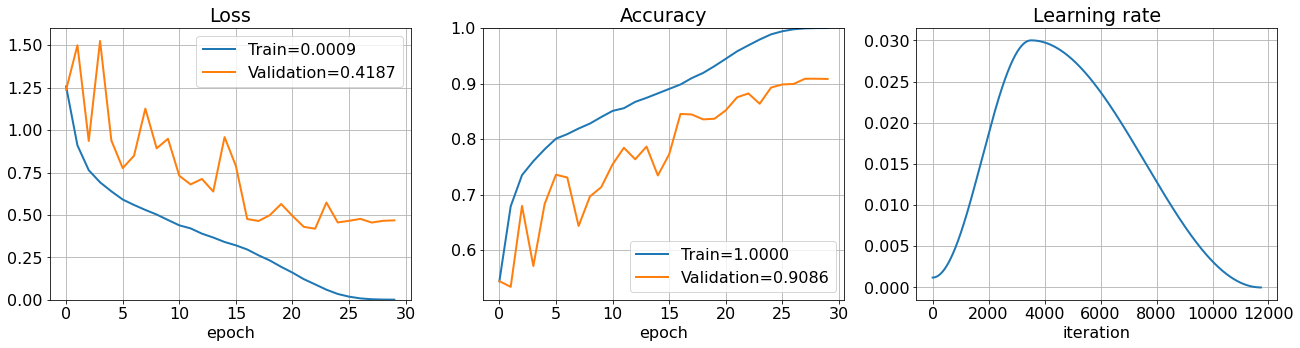

In [36]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc, vLR = lHistory
    
    _, vAx = plt.subplots(1, 3, figsize=(22, 5))
    
    vAx[0].plot      (vTrainLoss, lw=2, label='Train'      f'={vTrainLoss.min():.4f}')
    vAx[0].plot      (vValLoss,   lw=2, label='Validation' f'={vValLoss  .min():.4f}')
    vAx[0].set_title ('Loss')
    vAx[0].set_xlabel('epoch')
    vAx[0].set_ylim  (bottom=0)
    vAx[0].grid      ()
    vAx[0].legend    ()
    
    vAx[1].plot      (vTrainAcc, lw=2, label='Train'      f'={vTrainAcc.max():.4f}')
    vAx[1].plot      (vValAcc,   lw=2, label='Validation' f'={vValAcc  .max():.4f}')
    vAx[1].set_title ('Accuracy')
    vAx[1].set_xlabel('epoch')
    vAx[1].set_ylim  (top=1)
    vAx[1].grid      ()
    vAx[1].legend    ()
    

    vAx[2].plot      (vLR, lw=2)
    vAx[2].set_title ('Learning rate')
    vAx[2].set_xlabel('iteration')
    vAx[2].grid      ()
    
PlotHistory(lHistory)
plt.show   ()